## MVP - Qualidade de Software, Segurança e Sistemas Inteligentes
## Aluna: Paula Roberta de Melo Collatino

Esse notebook contém analises de variáveis relacionadas ao sono e hábitos diários. Inclui detalhes como sexo, idade, duração do sono, qualidade do sono, nível de atividade física, níveis de estresse, categoria de IMC, pressão arterial, frequência cardíaca, passos diários e presença ou ausência de distúrbios do sono.

In [49]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pickle import dump
from pickle import load
import joblib


## Carga do Dataset

In [50]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/paularmelo/mvp_qualidade_seguran-a_si/main/archive/Sleep_health_and_lifestyle_dataset_tratado.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,Person ID,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,1,27.0,6.1,6,42,6,2.0,126.83,77,4200,0
1,2,1,28.0,6.2,6,60,8,1.0,125.80,75,10000,0
2,3,1,28.0,6.2,6,60,8,1.0,125.80,75,10000,0
3,4,1,28.0,5.9,4,30,8,3.0,140.90,85,3000,1
4,5,1,28.0,5.9,4,30,8,3.0,140.90,85,3000,1


## Separação em conjunto de treino e conjunto de teste com holdout

In [51]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:11]
y = array[:,11]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

#Gerando arquivo para ser utilizado nos testes automatizado
#atributos = ['person_ID', 'gender', 'age', 'sleep_duration', 'quality_sleep', 'activity_level', 'stress_level', 'bmi_category', 'blood_pressure', 'heart_rate', 'daily_steps','disorder']
# Converter o array NumPy em um DataFrame Pandas
#df = pd.DataFrame(data= X_test, columns=atributos)

# Salvar os dados em um arquivo CSV
#df.to_csv('sleep_health_golden.csv', index=False)


### Criação e avaliação de modelos: linha base

KNN: 0.886207 (0.074969)
CART: 0.919770 (0.068596)
NB: 0.478851 (0.110878)
SVM: 0.588621 (0.039449)


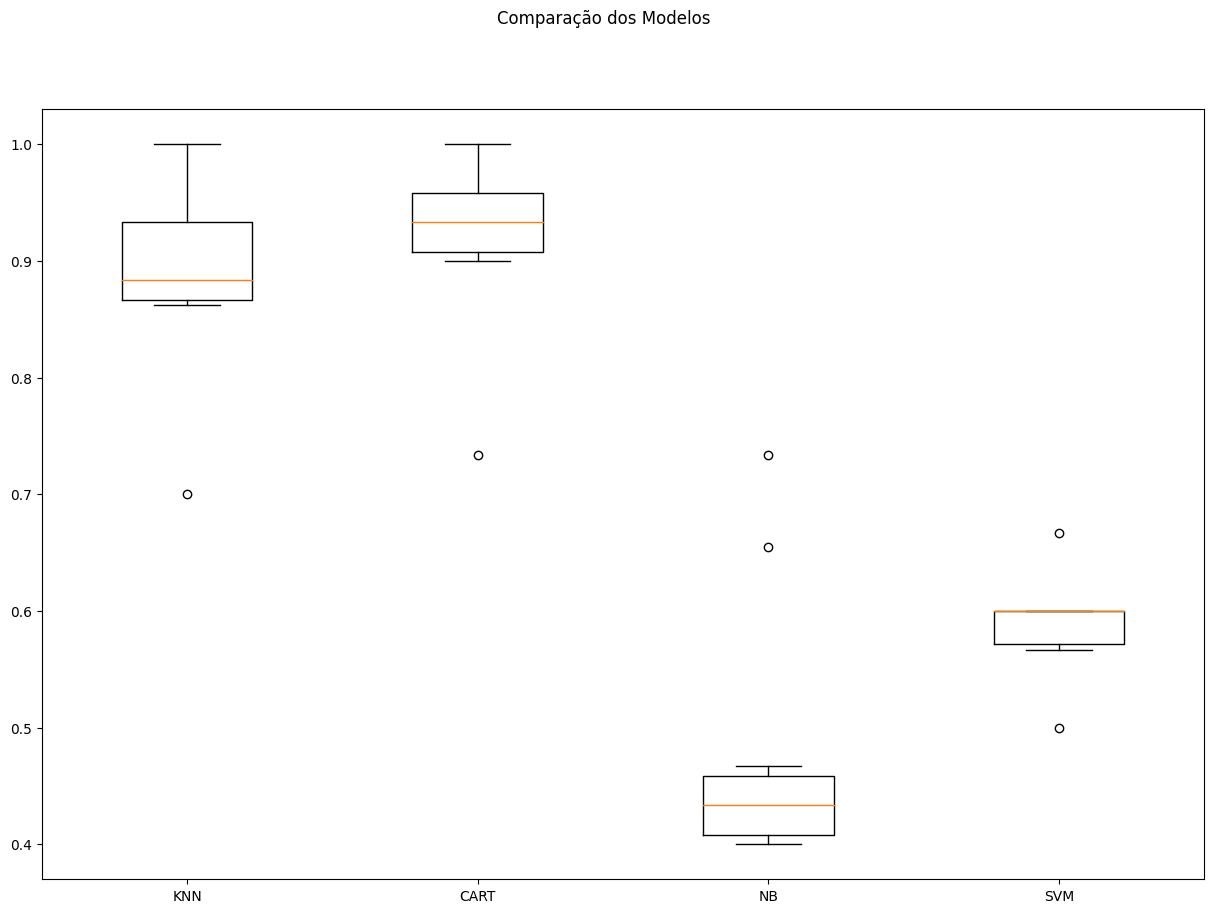

In [52]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.886 (0.075)
CART-orig: 0.920 (0.069)
NB-orig: 0.479 (0.111)
SVM-orig: 0.589 (0.039)
KNN-padr: 0.923 (0.065)
CART-padr: 0.903 (0.074)
NB-padr: 0.479 (0.111)
SVM-padr: 0.930 (0.066)
KNN-norm: 0.913 (0.081)
CART-norm: 0.910 (0.075)
NB-norm: 0.479 (0.111)
SVM-norm: 0.893 (0.065)


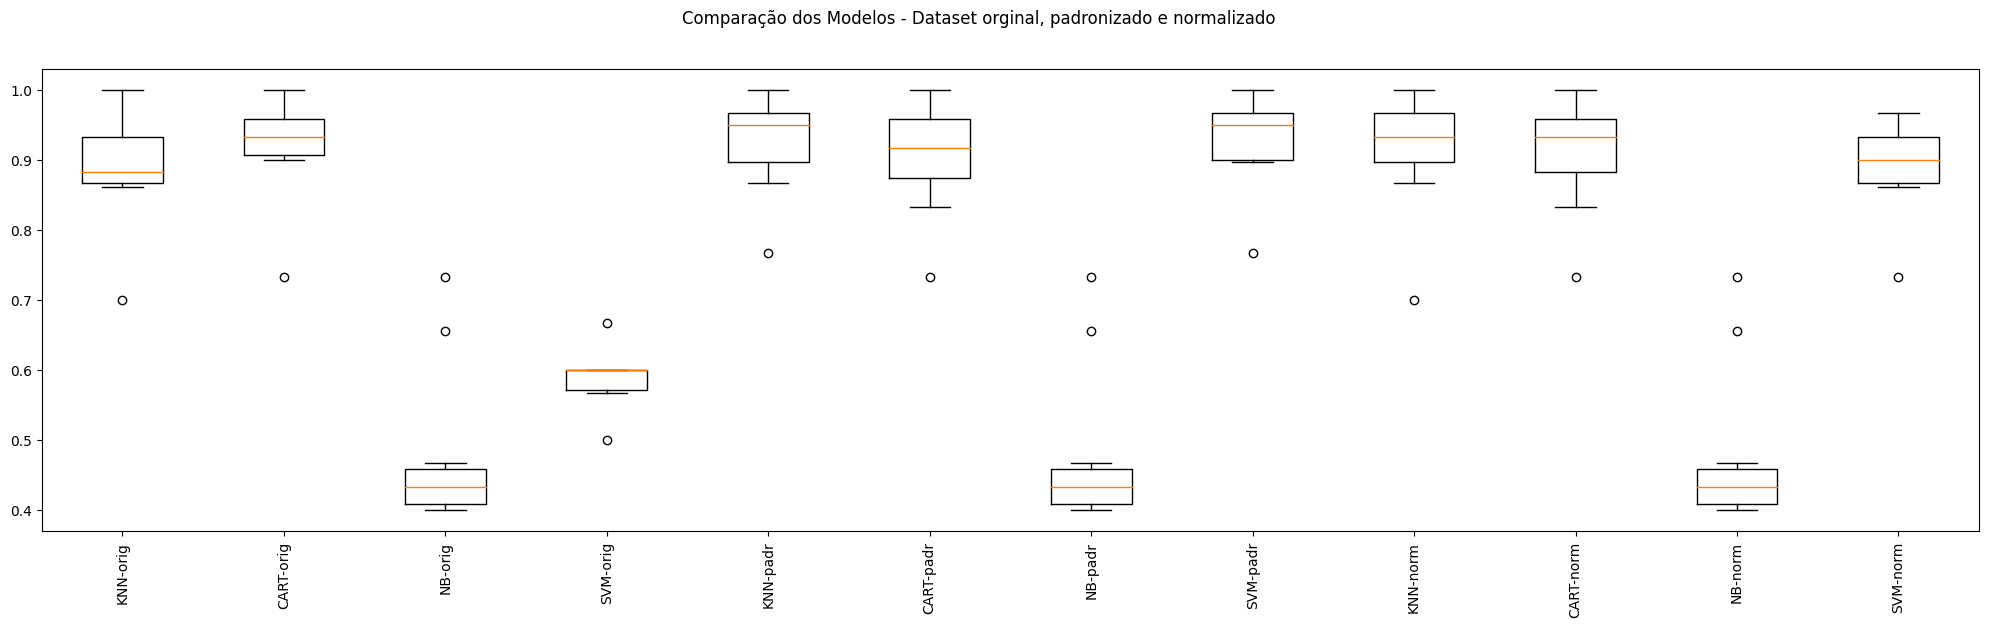

In [53]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [54]:
# Tuning do SVM

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline para SVM
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

#pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
#pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))


param_grid = {
    'SVM__C': [0.1, 1.0],
    'SVM__kernel': ['linear', 'rbf'],
    'SVM__gamma': ['scale', 'auto']
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: svm-padr - Melhor: 0.932989 usando {'SVM__C': 1.0, 'SVM__gamma': 'scale', 'SVM__kernel': 'linear'}


## Finalização do Modelo

In [55]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9466666666666667


In [56]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=17)

In [57]:
# @title Salvando o modelo usando a biblioteca Picke
artifact_pkl_filename = 'sleep_health.pkl'

local_path = artifact_pkl_filename
with open(local_path, 'wb') as model_file:
  pickle.dump(model, model_file)


In [58]:
# @title Salvando o mesmo modelo usando a biblioteca Joblib
joblib_filename = 'sleep_health.joblib'

local_path = joblib_filename
joblib.dump(model, local_path)


# Salvar o objeto de escala em um arquivo separado
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

## Simulando a aplicação do modelo em dados não vistos

In [59]:
# Novos dados - não sabemos a classe!
# Person ID,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
data = {'person_ID': [1,2,3,4],
        'gender':  [1, 0, 1,0],
        'age': [27, 43, 59,80],
        'sleep_duration': [6.1, 7, 5,4],
        'quality_sleep': [6, 7, 8, 7],
        'activity_level': [42, 35, 75, 20],
        'stress_level': [6, 8, 47, 70],
        'bmi_category': [3, 2, 1, 2],
        'blood_pressure': [126.83, 132.87, 120.80, 130],
        'heart_rate': [70, 75, 69, 70],
        'daily_steps': [4200, 8000, 3500, 1000],
        }

atributos = ['person_ID', 'gender', 'age', 'sleep_duration', 'quality_sleep', 'activity_level', 'stress_level', 'bmi_category', 'blood_pressure', 'heart_rate', 'daily_steps']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:11].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)


In [60]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 0. 0.]
